# UPMaBoSS notebook for the cell fate model

This Jupyter notebook implements all the analyses presented in the `UPMaBoSS: a tool for dynamic cell population
modeling` manuscript by Stoll et al., which will be available on [bioRxiv.org](https://www.biorxiv.org/search/uppmaboss) in the coming days (as of 2019-05-24).

There are two options to run this notebook.

1) With the corresponding docker image

All necessary software and files are available in the
[docker image for the CoLoMoTo notebook](http://www.colomoto.org/notebook)
starting with version `2019-05-24`. Further information and usage instructions are available
in the documentation of the CoLoMoTo notebook.
Launch the docker application on your desktop using the *colomoto-docker* wrapper with the following command:

    colomoto-docker -V 2019-05-24
    
This notebook can then be found in the folder: `usecases/Population-level Cell Fate with UpPMaBoSS`.


2) By creating a conda environment locally

We suggest to download miniconda3 and create an environment (here named named *umb*) with the following command:

     conda create -n umb -c colomoto -c potassco pymaboss notebook seaborn ginsim-python
     
To launch this environment, you need to activate it with the following command before launching the jupyter notebook:

    conda activate umb
    jupyter notebook

UPMaBoSS computes the evolution and the dynamics of a population of cells taking into account both their intracellular and intercellular regulations.

Simulations with UPMaBoSS are based on a logical model describing the intracellular regulations (logical regulatory graph complemented with logical rules), taking into account cell death, cell division, and intercellular communications. 

The logical model of an individual cell is described as a MaBoSS model. At predefined intervals, the simulation of the cell population is stopped and the status of each cell of the population is updated according to the value of the variables representing cell death and cell division, and the value of the variables accounting for the activation or inhibition of signals coming from other cells. The simulation is then continued with the updated conditions until the maximum simulation time is reached. Since MaBoSS results are probabilistic, the simulation outputs of UpPMaBoSS can be interpreted as the behaviour of a cell population. 

To run UPMaBoSS, three files are needed: a model file (in BND format), a configuration file with the transition rates, the simulation parameters and the initial conditions (in CFG format), and a file defining the update parameters (in UPP format).


The notebook presented illustrate the use of UPMaBoSS with the analysis of a modified version of the cell fate model previously published by Calzone et al. (2010). Three files related to the logical model used for the analysis are provided together with this notebook:
- the model files: *CellFateModel_uppmaboss.bnd* and *CellFateModel_uppmaboss.cfg*
- the update configuration file for UPMaBoSS: *CellFateModel_uppmaboss.upp* 

The code included in the following cell sets the working environment, and particular load different libraries required to run the notebook.

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import maboss
import ginsim
import time

# Set seaborn style and create color maps: white-black scale and blue-light-red for ratios
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)

# Shortcut to save figures with a common pattern and format
def save_figure(figure, title):
    figure.savefig("figure_%s.pdf" % title, bbox_inches="tight")

The original cell fate model (Calzone et al., 2010) was defined to study the cell fate decision process in response to the engagement of the death receptors TNFR and Fas.  Depending to the presence of the corresponding  ligands, several pathways can be activated: survival through NFkB activation, death through necrosis (NonACD), or apoptosis. 
This model has been extended to account for a documented activation of TNFalpha by NFkB (bold arrow), as well as by the addition of two output nodes DIVISION and DEATH, as shown in the regulatory graph using GINsim with the following command line. 

In [2]:
lrg = ginsim.load("http://ginsim.org/sites/default/files/CellFate_multiscale.zginml")
ginsim.show(lrg)

/home/gstoll/Shared/CompStrucBioRevMaBoSS/UPMaBoSSJup/CellFate_multiscale.zginml

The BND file lists all the logical rules for each of the variables.
The CFG file defines all the parameters for the simulations (transition rates, simulation parameters and initial conditions).
The UPP file informs on the intercellular conditions and population updates.
These files are loaded with the code contained in the following cell.

In [3]:
# Set up the required files
bnd_file ="CellFateModel_uppmaboss.bnd"
cfg_WT = "CellFateModel_uppmaboss.cfg"
upp_file = "CellFateModel_uppmaboss.upp"

# MaBoSS simulation of the wild type model

Before running UPMaBoSS, we strongly suggest to run an initial simulation of the wild type model with MaBoSS for the whole simulation time. This enables the user to verify how the population behaves in a normal MaBoSS run without taking into account cell death or cell division.  Here, the total (virtual) simulation time is 48 hours. 
The output results are restricted to the three model nodes "Death", "Division" and "NFkB". Other nodes can be considered in the output, but the most important is to select all the nodes that are used for population updating, as shown in the UPP file below. By considering these nodes in the output, MaBoSS computes explicitly the values of these nodes.

In [4]:
ufile = open(upp_file, 'r') 
print(ufile.read())
ufile.close()

death = Death;
division = Division ;
$TNF_induc u= $ProdTNF_NFkB*p[(NFkB,Death) = (1,0)];
steps = 48;
MaBoSS = MaBoSS



In [5]:
# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)

# Set some parameters in the cfg file: "max_time" 
# and select the variables considered to be internal (not appearing in the resulting csv file)
# here, only the two outputs will appear: Death and Division in the figures
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})
start = time.time()
run_48h = model_48h.run()
stop = time.time()
duration = (stop-start)/60
print("exec. time: ",duration," mins")
for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
    model_48h.network[name].is_internal = True


exec. time:  0.04870942036310832  mins


Next, we define the nodes considered in the output and launch the simulation with the following command lines:

In [6]:
model_48h.network.set_output(('Apoptosis','NonACD','Survival'))
run_48h = model_48h.run()

The result of the simulation can be displayed with the following command line:

,Apoptosis,NonACD,Survival
0.0,0.00000,0.00000,0.000000
0.1,0.00000,0.00000,0.000000
0.2,0.00000,0.00000,0.000000
0.3,0.00000,0.00000,0.000000
0.4,0.00000,0.00000,0.000000
...,...,...,...
47.4,0.26637,0.08502,0.022135
47.5,0.26637,0.08502,0.022068
47.6,0.26637,0.08502,0.022009
47.7,0.26637,0.08502,0.021924


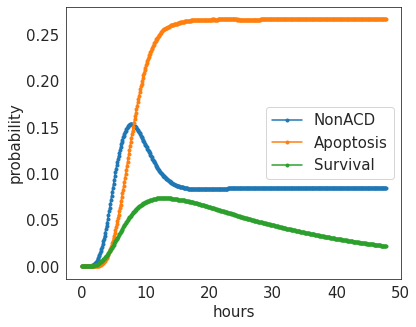

In [7]:
# Plot the results of the WT simulation
figure = plt.figure(figsize = (6,5))
plt.rcParams.update({'legend.fontsize': 15})
outPlot = run_48h.get_nodes_probtraj().plot(ax=plt.gca(),fontsize=15,marker =".")
outPlot.set_xlabel("hours",fontsize=15)
outPlot.set_ylabel("probability",fontsize=15)
save_figure(figure, 'MaBoSS_phenotypes')
run_48h.get_nodes_probtraj()

,Apoptosis,NonACD,Survival
0.0,0.00000,0.0,0.000000
0.1,0.00000,0.0,0.000000
0.2,0.00000,0.0,0.000000
0.3,0.00000,0.0,0.000000
0.4,0.00000,0.0,0.000000
...,...,...,...
47.4,0.27654,0.0,0.026331
47.5,0.27654,0.0,0.026237
47.6,0.27654,0.0,0.026149
47.7,0.27654,0.0,0.026067


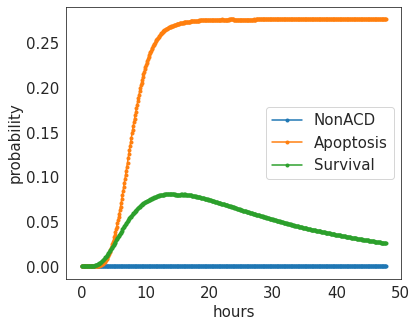

In [8]:
model_ROSOff = maboss.copy_and_mutate(model_48h, ["ROS"], 'OFF')
run_ROSOff = model_ROSOff.run()
figure = plt.figure(figsize = (6,5))
plt.rcParams.update({'legend.fontsize': 15})
outPlot = run_ROSOff.get_nodes_probtraj().plot(ax=plt.gca(),fontsize=15,marker = ".")
outPlot.set_xlabel("hours",fontsize=15)
outPlot.set_ylabel("probability",fontsize=15)
save_figure(figure, 'MaBoSS_phenotypes_ROSOff')
run_ROSOff.get_nodes_probtraj()

This graph shows the mean temporal profiles of the nodes Apoptosis, Division, NonACD and Survival computed for 100,000 trajectories (as specified in the BND file) simulations over 48h. 

# UPMaBoSS simulations

We now wish to explore the population dynamics for the cell fate model considering cell death, cell division and intercellular events. 
To do so, we divide the 48 hours into 48 runs (the variable "steps" is set to 48 in CellFateModel_uppmaboss.upp file) of 1 for each time steps (the variable "max_time" is set to 1 in CellFateModel_uppmaboss.cfg file). This choice of the value 1 is based on the analysis of the profile of the MaBoSS simulation above, as such a time-step enables to capture transient changes of activities of the output nodes Death, Division and NFkB.

The following code cell run UpPMaBoSS on the WT model, calling iteratively 48 times MaBoSS and updating the input variables between each of these calls.

In [11]:
# Run UPMaBoSS on the WT model and collect population ratios
# A folder named "WT" "is created with the 48 runs
uppModel_WT = maboss.UpdatePopulation(model_WT, upp_file)
start = time.time()
run_WT = uppModel_WT.run()
stop = time.time()
duration = (stop-start)/60
print("exec. time: ",duration," mins")
pop_ratios_WT = run_WT.get_population_ratios('NFkB -> TNF')

exec. time:  0.37021220525105797  mins


and then continue this simulation with constant TNF.

In [12]:
# Create a model for a second treatment of TNF
model_reTNF = maboss.copy_and_update_parameters(model_WT, {'$TNF_induc': 20})

# Run UPMaBoSS for the second treatment of TNF after a WT run with TNF ON
# A folder named "TNF_reTNF" is created with the 48 runs
uppModel_TNF_reTNF = maboss.UpdatePopulation(model_reTNF, upp_file, previous_run=run_WT)
run_TNF_reTNF = uppModel_TNF_reTNF.run('TNF_reTNF')
pop_ratios_TNF_reTNF = run_TNF_reTNF.get_population_ratios('TNF')
# Control
model_reTNF_ctrl = maboss.copy_and_update_parameters(model_WT, {'$TNF_induc': 0})
model_reTNF_ctrl.network.set_istate('TNF', {0: 1, 1: 0})
uppModel_TNF_reTNF_ctrl = maboss.UpdatePopulation(model_reTNF_ctrl, upp_file, previous_run=run_WT)
run_TNF_reTNF_ctrl = uppModel_TNF_reTNF_ctrl.run('TNF_reTNF_ctrl')
pop_ratios_TNF_reTNF_ctrl = run_TNF_reTNF_ctrl.get_population_ratios('TNF')



Next, we plot the population ratios computed for the protocol: 
(Pulse of TNF) + TNF, 

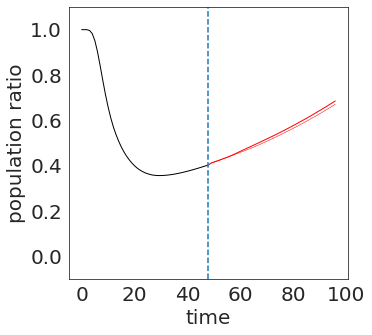

In [13]:
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation
# A figure "figure_two_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (5,5))
plt.rcParams.update({'legend.fontsize': 15})
pop_ratios_WT.name = "TNFPulse"
pop_ratios_WT.plot(style='-k', legend=False,fontsize=20,ylabel="population ratio",ylim=(-0.1,1.1),linewidth = 1)
# pop_ratios_noTNF.plot(style='.-b', legend=False)
pop_ratios_TNF_reTNF.plot(style='-r', legend=False,linewidth = 1)
pop_ratios_TNF_reTNF_ctrl.plot(style='-r', legend=False,linewidth = .5)
plt.xlabel("time",fontsize=20)
plt.ylabel("population ratio",fontsize=20)
plt.axvline(x=48,ls="--")
# pop_ratios_noTNF_reTNF.plot(style='.-g', legend=False)
save_figure(figure, 'two_steps_ratios')